## Imports

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, make_scorer

from scipy.stats import spearmanr

import tensorflow as tf

from copy import deepcopy

import shap

from visualization import plot_predicted_vs_true

In [2]:
np.set_printoptions(suppress=True)

## Data Preparation

In [3]:
# Import the data

data = pd.read_csv("data/stress_factors.csv")


In [4]:
# Create factorized version
# One-hot encode the categorical columns
data_encoded = pd.get_dummies(data, drop_first=True)

# Standardize the data (important for PCA)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_encoded)

In [5]:
# Organize column names

predictors = ["Sleep_Quality","Weekly_Headaches","Academic_Performance","Study_Load","Weekly_Extracurriculars"]
targets = ["Stress_Level"]

In [6]:
# Assert that there are no NAs
assert(data.isna().sum().sum() == 0)

## Data Summary Statistics

In [7]:
# Basic summary
summary = data.describe()

# Add MADs
sum_columns = summary.columns
mads = [np.median(np.abs(data[column] - data[column].median())) for column in sum_columns]

summary.loc['mad'] = mads

# Formatting
summary = round(summary, 3)


In [8]:
# Display summary
summary

,Sleep_Quality,Weekly_Headaches,Academic_Performance,Study_Load,Weekly_Extracurriculars,Stress_Level
count,520.000,520.000,520.000,520.000,520.000,520.000
mean,3.125,2.183,3.327,2.750,2.683,2.875
std,1.099,1.247,1.061,1.372,1.471,1.358
min,1.000,1.000,1.000,1.000,1.000,1.000
25%,2.000,1.000,3.000,2.000,1.000,2.000
50%,3.000,2.000,3.000,2.500,3.000,3.000
75%,4.000,3.000,4.000,4.000,4.000,4.000
max,5.000,5.000,5.000,5.000,5.000,5.000
mad,1.000,1.000,1.000,1.500,1.000,1.000


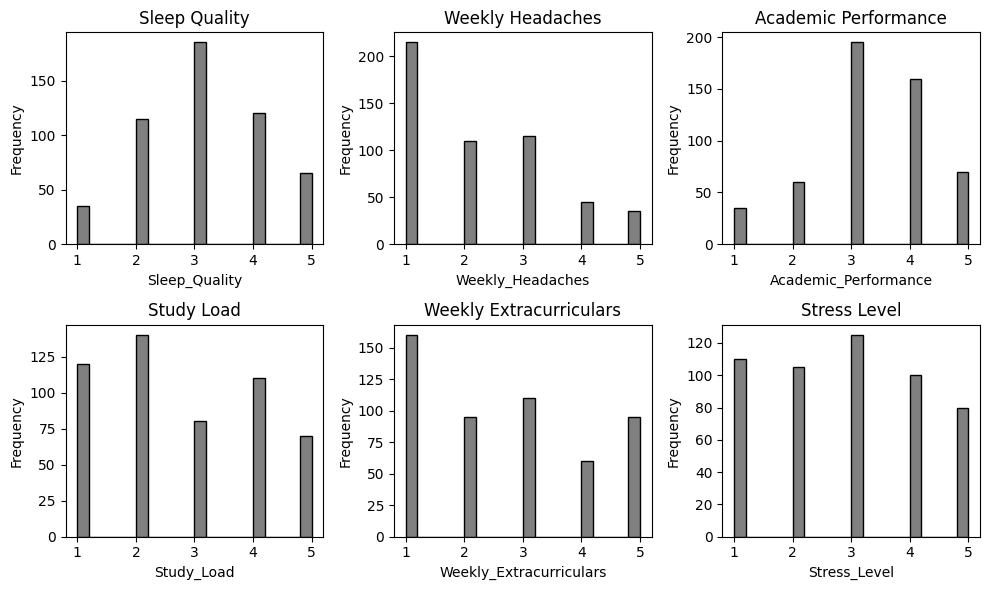

In [9]:
# Set number of columns in the grid
data_to_plot = data
n_cols = 3
n_rows = int(np.ceil(len(data_to_plot.columns) / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axes = axes.flatten()  # Flatten in case it's 2D

# Plot histograms
for i, col in enumerate(data_to_plot.columns):
    axes[i].hist(data_to_plot[col], bins=20, color='grey', edgecolor='black')
    axes[i].set_title(f'{col.replace("_", " ")}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Factor Analysis

### Factor Analysis Pre-Work

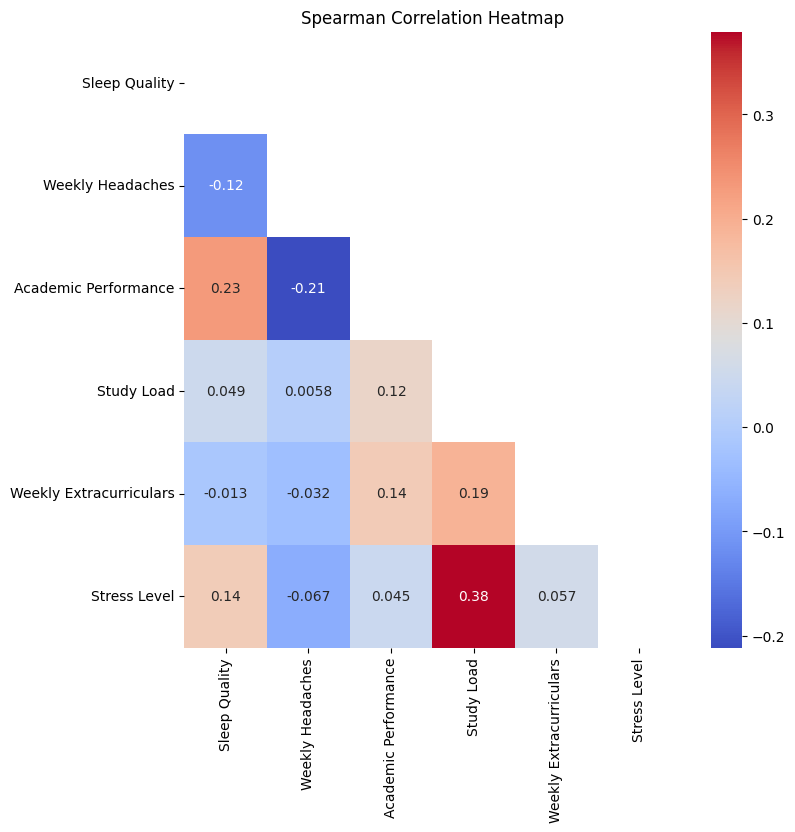

In [10]:
# Compute Spearman correlation matrix
corr, _ = spearmanr(data_scaled)

corr_subset = corr[:6, :6]
labels = list(map(lambda x: x.replace("_", " "), data_encoded.columns))
labels_subset = labels[:6]
mask = np.triu(np.ones_like(corr_subset, dtype = bool))

# Create a heatmap
# labels = list(map(lambda x: x.replace("_", " "), data_encoded.columns))
plt.figure(figsize=(8, 8))
sns.heatmap(corr_subset, mask = mask, annot=True, xticklabels=labels_subset, yticklabels=labels_subset, cmap="coolwarm")
plt.title('Spearman Correlation Heatmap')
plt.show()

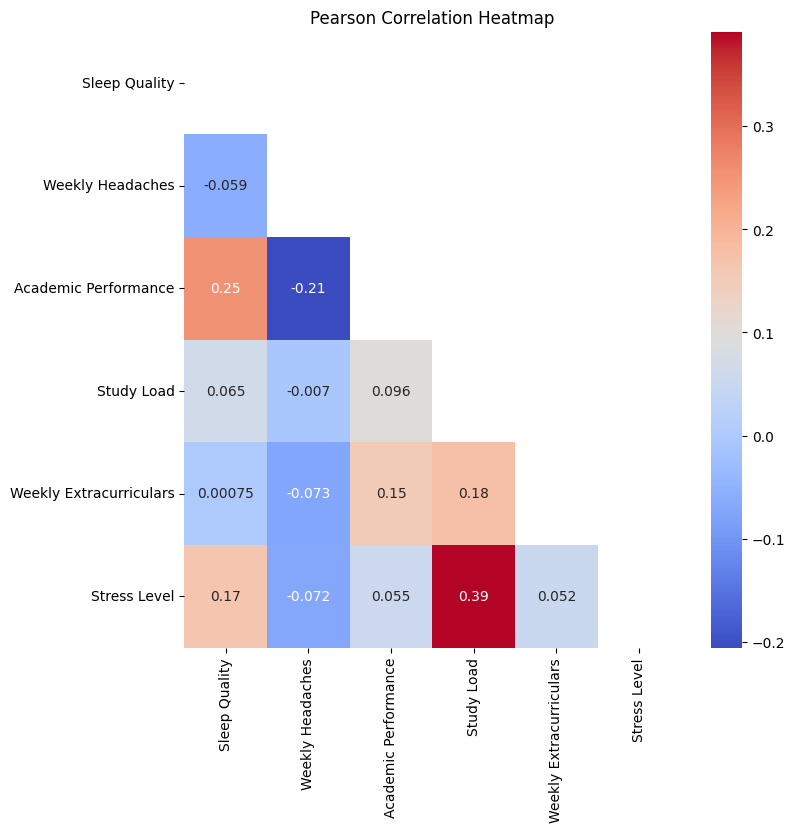

In [11]:
# Compute Pearson correlation matrix
data_scaled_df = pd.DataFrame(data_scaled, columns=data_encoded.columns)
corr = data_scaled_df.corr(method='pearson')

corr_subset = corr.iloc[:6, :6]
labels = list(map(lambda x: x.replace("_", " "), data_encoded.columns))
labels_subset = labels[:6]
mask = np.triu(np.ones_like(corr_subset, dtype = bool))

# Create a heatmap
# labels = list(map(lambda x: x.replace("_", " "), data_encoded.columns))
plt.figure(figsize=(8, 8))
sns.heatmap(corr_subset, mask = mask, annot=True, xticklabels=labels_subset, yticklabels=labels_subset, cmap="coolwarm")
plt.title('Pearson Correlation Heatmap')
plt.show()

### Factor Analysis Fits

In [33]:
# Step 1: Standardize the data (mean centering)
X_mean = np.mean(corr_subset, axis=0)
X_centered = corr_subset - X_mean

# Step 2: Compute the covariance matrix
cov_matrix = np.cov(X_centered, rowvar=False)

# Step 3: Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Step 4: Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

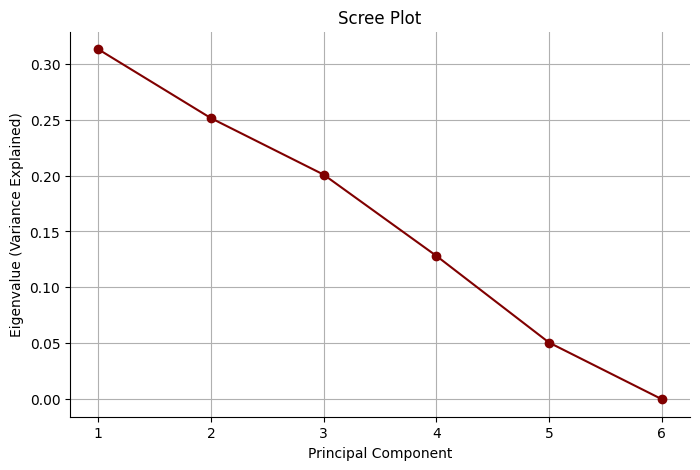

In [34]:
# Scree plot ("explained variance" by each principal component)
f, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(range(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, marker='o', linestyle='-', color="maroon")
ax.set_xlabel('Principal Component')
ax.set_ylabel('Eigenvalue (Variance Explained)')
ax.set_title('Scree Plot')
ax.grid(True)
sns.despine(ax=ax)

### Factor Analysis Evaluations

In [ ]:
# Skip this because our scree plot sucks

## Regression Models

### Regression Model Fits

In [ ]:
# Parameters for model fits
linear_fit_params = dict()
random_forest_params = dict()
nn_model_params = dict(
    batch_size=32, 
    epochs=150, 
    validation_split=0.1
)

# List of valid model types
valid_model_types = ["lin", "lin_3", "lin_8", "rf", "rf_3", "rf_8", "nn", "nn_3", "nn_8"]

# Model fit helper functions
def fit_model(model, x_train, y_train, **kwargs): 
    """
    Fits a single model

    Parameters:
    -----------
    model   : an object with a .fit() method
            Values are model types, from
    x_train : pd.DataFrame
            The training inputs
    y_train : pd.DataFrame
            The training outputs
    kwargs  : dict
            A dictionary containing any keyword arguments to be passed
            to model.fit()

    Returns:
    --------
    Nothing 
    """
    model.fit(x_train, y_train, **kwargs)

def fit_models(models: dict, x_train, y_train): 
    """
    Fits a series of models

    Parameters:
    -----------
    models  : dict
            Values are model types, from
    x_train : pd.DataFrame
            The training inputs
    y_train : pd.DataFrame
            The training outputs
    kwargs  : dict
            A dictionary containing any keyword arguments to be passed
            to model.fit()

    Returns:
    --------
    Nothing 
    """
    for model_type, model in models.items():

        # Ensure model is valid
        if model_type not in valid_model_types: 
            raise Exception("Unknown model type")
        
        # Run fit with appropriate params
        if model_type.startswith("lin"):
            fit_model(x_train, y_train, **linear_fit_params)
            return
        elif model_type.startswith("rf"): 
            fit_model(x_train, y_train, **random_forest_params)
        else: 
            fit_model(x_train, y_train, **nn_model_params)



### Regression Model Evaluations